https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms

In [21]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

mps


# loading the cifar data

In [22]:
# transforms for loading data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ]
)

batch_size = 4

# training data
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# testing data
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# cifar specific classes
classes = (
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Visualizing loaded data

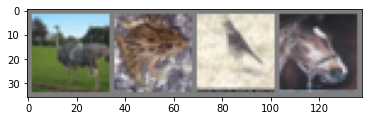

bird  frog  bird  horse


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# Defining the CNN model

In [24]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
cnn = CNN()
cnn.to(device)
print(cnn)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [26]:
next(cnn.parameters()).device

device(type='mps', index=0)

# Training process

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001) #, momentum=0.9)

In [28]:
print('Starting Training')

epochs = 10

for epoch in range(epochs):
    running_loss = 0.

    for i, data in enumerate(trainloader, 0):
        # data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # pytorch specific zero_gradient in training process
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)  # forward pass
        loss = criterion(outputs, labels)  # loss fn
        loss.backward()  # back propogation
        optimizer.step()  # optimization step

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Starting Training
[1,  2000] loss: 1.876
[1,  4000] loss: 1.609
[1,  6000] loss: 1.511
[1,  8000] loss: 1.469
[1, 10000] loss: 1.436
[1, 12000] loss: 1.411
[2,  2000] loss: 1.324
[2,  4000] loss: 1.304
[2,  6000] loss: 1.288
[2,  8000] loss: 1.278
[2, 10000] loss: 1.258
[2, 12000] loss: 1.261
[3,  2000] loss: 1.187
[3,  4000] loss: 1.187
[3,  6000] loss: 1.176
[3,  8000] loss: 1.175
[3, 10000] loss: 1.171
[3, 12000] loss: 1.153
[4,  2000] loss: 1.120
[4,  4000] loss: 1.112
[4,  6000] loss: 1.145
[4,  8000] loss: 1.109
[4, 10000] loss: 1.103
[4, 12000] loss: 1.121
[5,  2000] loss: 1.052
[5,  4000] loss: 1.058
[5,  6000] loss: 1.069
[5,  8000] loss: 1.059
[5, 10000] loss: 1.069
[5, 12000] loss: 1.066
[6,  2000] loss: 1.000
[6,  4000] loss: 1.014
[6,  6000] loss: 1.023
[6,  8000] loss: 1.030
[6, 10000] loss: 1.012
[6, 12000] loss: 1.040
[7,  2000] loss: 0.983
[7,  4000] loss: 0.989
[7,  6000] loss: 1.008
[7,  8000] loss: 0.998
[7, 10000] loss: 0.991
[7, 12000] loss: 0.983
[8,  2000] loss:

In [29]:
# saving model
PATH = './models/cifar_net.pth'
torch.save(cnn.state_dict(), PATH)

In [30]:
# loading model
# cnn = Net()
# cnn.load_state_dict(torch.load(PATH))

# validating the network

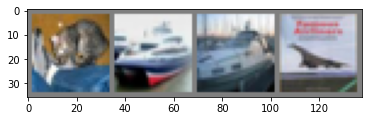

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  plane plane


In [31]:
dataiter = next(iter(testloader))
images, labels = dataiter[0].to(device), dataiter[1].to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# model predictions
outputs = cnn(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

## standard accuracy metric

In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


## simple class based distribution analysis

In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 75.1 %
Accuracy for class: car   is 71.4 %
Accuracy for class: bird  is 47.6 %
Accuracy for class: cat   is 37.8 %
Accuracy for class: deer  is 62.3 %
Accuracy for class: dog   is 43.0 %
Accuracy for class: frog  is 70.2 %
Accuracy for class: horse is 72.2 %
Accuracy for class: ship  is 73.5 %
Accuracy for class: truck is 84.3 %
